In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
random.seed(7)
gc.collect()

11

In [3]:
def ptime():
    print(datetime.datetime.now().time())
    return time.time()
start = ptime()
execution_time = ptime() - start
def ptime2(execution_time):
    print(f'{round(execution_time, 6)}s')
ptime2(execution_time)

01:27:10.720998
01:27:10.721133
7.4e-05s


In [4]:
def read_dataset(path):
    start = ptime()
    gc.collect()
    df = pd.read_csv(path)
    print(df.shape)
    df = df.dropna()
    print(df.shape)
    execution_time = ptime() - start
    ptime2(execution_time)
    return df

def reduce_mem_usage(df):
    start = ptime()
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.6f} MB'.format(start_mem))
    
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    for col in features:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    execution_time = ptime() - start
    ptime2(execution_time)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.6f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def mae(X_to_test, y_to_test, model_to_test):
    start = ptime()
    y_pred_test = model_to_test.predict(X_to_test)
    mae =  mean_absolute_error(y_to_test, y_pred_test)
    execution_time = ptime() - start
    ptime2(execution_time)
    return mae

In [6]:
df = read_dataset('../data/small_train_FE.csv')

01:28:54.243771
(444697, 37)
(444697, 37)
01:28:57.918130
3.674333s


In [7]:
df.shape

(444697, 37)

In [8]:
df = reduce_mem_usage(df)
df.shape

01:29:16.815621
Memory usage of dataframe is 128.925217 MB
01:29:17.261398
0.4457s
Memory usage after optimization is: 40.289130 MB
Decreased by 68.8%


(444697, 37)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444697 entries, 0 to 444696
Data columns (total 37 columns):
Id                          444697 non-null object
groupId                     444697 non-null object
matchId                     444697 non-null object
assists                     444697 non-null int8
boosts                      444697 non-null int8
damageDealt                 444697 non-null float16
DBNOs                       444697 non-null int8
headshotKills               444697 non-null int8
heals                       444697 non-null int8
killPlace                   444697 non-null int8
killPoints                  444697 non-null int16
kills                       444697 non-null int8
killStreaks                 444697 non-null int8
longestKill                 444697 non-null float16
matchDuration               444697 non-null int16
matchType                   444697 non-null object
maxPlace                    444697 non-null int8
numGroups                   444697 non-n

In [12]:
matchTypeList = df['matchType'].unique()
print(matchTypeList)
print(len(matchTypeList))

['duo' 'squad' 'squad-fpp' 'solo-fpp' 'duo-fpp' 'solo' 'normal-squad-fpp'
 'flaretpp' 'normal-duo-fpp' 'normal-squad' 'crashfpp' 'normal-solo-fpp'
 'crashtpp' 'normal-solo' 'flarefpp' 'normal-duo']
16


In [13]:
cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
features = [col for col in df.columns if col not in cols_to_drop]
df[features].shape

(444697, 33)

In [14]:
print([(df[features].columns.get_loc(c),c) for c in df[features].columns])

[(0, 'assists'), (1, 'boosts'), (2, 'damageDealt'), (3, 'DBNOs'), (4, 'headshotKills'), (5, 'heals'), (6, 'killPlace'), (7, 'killPoints'), (8, 'kills'), (9, 'killStreaks'), (10, 'longestKill'), (11, 'matchDuration'), (12, 'matchType'), (13, 'maxPlace'), (14, 'numGroups'), (15, 'rankPoints'), (16, 'revives'), (17, 'rideDistance'), (18, 'roadKills'), (19, 'swimDistance'), (20, 'teamKills'), (21, 'vehicleDestroys'), (22, 'walkDistance'), (23, 'weaponsAcquired'), (24, 'winPoints'), (25, 'healsandboosts'), (26, 'total_distance'), (27, 'headshotKills_over_kills'), (28, 'killPlace_over_maxPlace'), (29, 'walkDistance_over_heals'), (30, 'walkDistance_over_boosts'), (31, 'walkDistance_over_kills'), (32, 'teamwork')]


# WITH matchType

# GETTING X AND Y 

In [29]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

In [16]:
# Separating X and y
X = df[cols_to_fit].values
y = df['winPlacePerc'].values
# y = np.array(y).reshape(-1,1)
print(X.shape)
print(y.shape)
print(df[cols_to_fit].columns.get_loc("matchType"))

# Encoding categorical data named matchType
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 12] = labelencoder_X_1.fit_transform(X[:, 12])
print(X.shape)
onehotencoder = OneHotEncoder(categorical_features = [12])
X = onehotencoder.fit_transform(X).toarray()
print(X.shape)
X = X[:, 1:] # removing first, so need to know first var name
print(X.shape)

(444697, 33)
(444697,)
12
(444697, 33)


/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


(444697, 48)
(444697, 47)


# Splitting the dataset into the Training set and Test set

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

# FITTING XGBOOST

In [23]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [24]:
start = ptime()
model_v1 = XGBRegressor()
model_v1.fit(X_train,y_train)
execution_time = ptime() - start
ptime2(execution_time)

01:36:19.847347
01:37:06.662845
46.815351s


In [28]:
print(model_all)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


# MAE TRAIN

In [25]:
mae_v1_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_v1)
print(mae_v1_train)

01:43:23.054839
01:43:24.078357
1.023339s
0.06866783889702577


# MAE TEST

In [26]:
mae_v1_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_v1 )
print(mae_v1_test)

01:43:53.158091
01:43:53.294789
0.136577s
0.06881869204451482


# PLOT model_v1

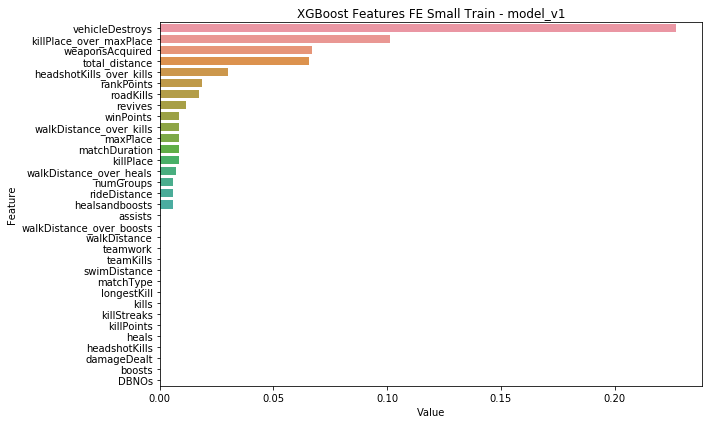

In [30]:
feature_importance = pd.DataFrame(sorted(zip(model_v1.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features FE Small Train - model_v1')
plt.tight_layout()

# NEW XGBOOST

In [38]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId',target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

In [40]:
# Separating X and y
X = df[cols_to_fit].values
y = df['winPlacePerc'].values
# y = np.array(y).reshape(-1,1)
print(X.shape)
print(y.shape)

print(df[cols_to_fit].columns.get_loc("matchType"))

# Encoding categorical data named matchType
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 12] = labelencoder_X_1.fit_transform(X[:, 12])
print(X.shape)
onehotencoder = OneHotEncoder(categorical_features = [12])
X = onehotencoder.fit_transform(X).toarray()
print(X.shape)
X = X[:, 1:] # removing first, so need to know first var name
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

start = ptime()
model_v12 = XGBRegressor(max_depth=10)
model_v12.fit(X_train,y_train)
execution_time = ptime() - start
ptime2(execution_time)

(444697, 33)
(444697,)
12
(444697, 33)


/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/axeljeremy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


(444697, 48)
(444697, 47)
01:54:02.951093
01:56:57.520817
174.569798s


# MAE TRAIN

In [42]:
mae_v12_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_v12)
print(mae_v12_train)

01:57:13.309323
01:57:18.660394
5.350941s
0.051271081237670595


# MAE TEST

In [43]:
mae_v12_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_v12 )
print(mae_v12_test)

01:57:22.158477
01:57:22.945152
0.786516s
0.05747944829337324


# PLOT model_v12

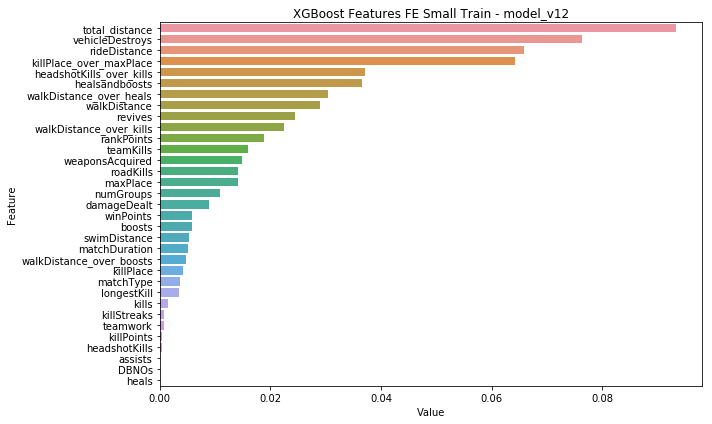

In [44]:
feature_importance = pd.DataFrame(sorted(zip(model_v12.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features FE Small Train - model_v12')
plt.tight_layout()

# SECOND PART

# WITH NO MATCHTYPE

# GETTING X AND Y

In [45]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType',target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

# Separating X and y
X = df[cols_to_fit].values
y = df['winPlacePerc'].values
# y = np.array(y).reshape(-1,1)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

(444697, 32)
(444697,)


# FITTING XGBOOST

In [46]:
start = ptime()
model_v21 = XGBRegressor()
model_v21.fit(X_train,y_train)
execution_time = ptime() - start
ptime2(execution_time)

02:01:02.779309
02:01:38.215653
35.43641s


# MAE TRAIN

In [47]:
mae_v21_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_v21)
print(mae_v21_train)

02:01:41.991538
02:01:43.026263
1.03453s
0.0686276412240065


# MAE TEST

In [48]:
mae_v21_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_v21 )
print(mae_v21_test)

02:01:49.059303
02:01:49.190225
0.130921s
0.0687989183885745


# PLOT 

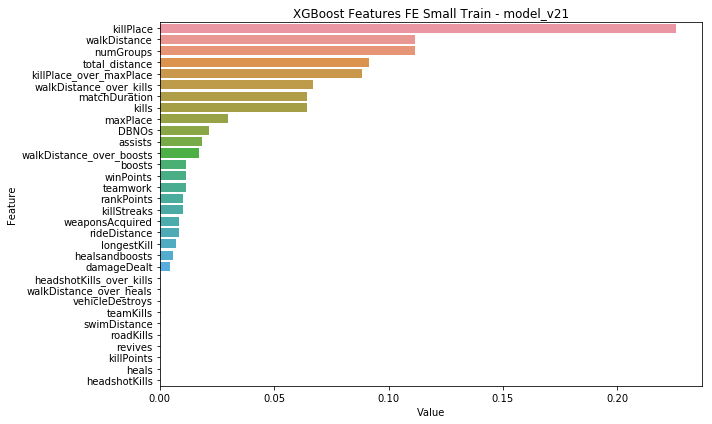

In [49]:
feature_importance = pd.DataFrame(sorted(zip(model_v21.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features FE Small Train - model_v21')
plt.tight_layout()

# FITTING NEW XGBOOST

In [50]:
start = ptime()
model_v22 = XGBRegressor(max_depth=10, learning_rate=0.5)
model_v22.fit(X_train,y_train)
execution_time = ptime() - start
ptime2(execution_time)

02:02:32.251411
02:04:39.920084
127.668387s


# MAE TRAIN

In [51]:
mae_v22_train = mae(X_to_test=X_train, y_to_test= y_train,model_to_test=model_v22)
print(mae_v22_train)

02:05:18.297444
02:05:22.229687
3.932265s
0.04427238264962771


# MAE TEST

In [52]:
mae_v22_test = mae(X_to_test=X_test, y_to_test=y_test,model_to_test=model_v22 )
print(mae_v22_test)

02:05:24.680449
02:05:25.260695
0.580038s
0.061641434936032344


# PLOT 

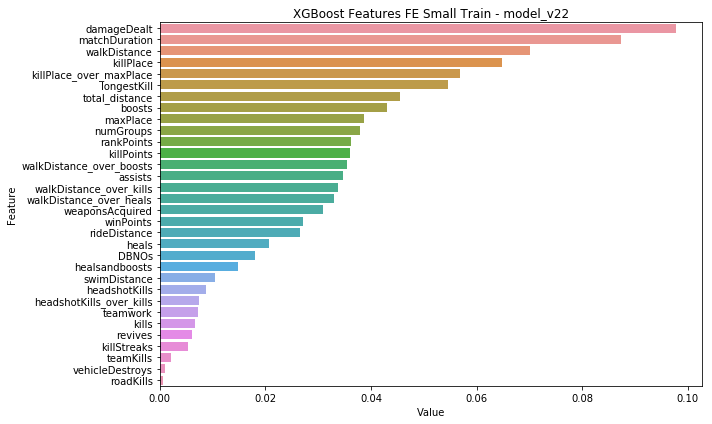

In [53]:
feature_importance = pd.DataFrame(sorted(zip(model_v22.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features FE Small Train - model_v22')
plt.tight_layout()

In [54]:
from sklearn.externals import joblib
# Save to file in the current working directory
joblib_file = "model_v22_fe.pkl"  
joblib.dump(model_v22, joblib_file)

joblib_file = "model_v21_fe.pkl"  
joblib.dump(model_v21, joblib_file)

joblib_file = "model_v1_fe.pkl"  
joblib.dump(model_v1, joblib_file)

joblib_file = "model_v12_fe.pkl"  
joblib.dump(model_v12, joblib_file)

# Load from file
# joblib_model = joblib.load(joblib_file)

['model_v12_fe.pkl']